## Approximation of watch wearing statistics from detected events 
1. [Import necessary libraries and get episode data of pariticipants](#Extract-episodes-data)
2. [Data cleaning, filtering- remove duplicate entries, take participants with at least one annotation leaving out self-initiated annotations](#Data-cleaning-and-filtering)
3. [Assign watch wearing segment number to model detected episodes, accouting for different time gaps](#Assign-watch-wearing-segments-daywise-+-aggregate-information-of-the-same-segment)
4. [Due to the stress detection model running on the watch, watch battery usually lasted for 5-6 hours in one charging cycle. Considering charging burden, it is expected that most participants will charge the watch at most twice a day, during sleeping hours and another time during the day. So, watch wearing cycles should be close to 2 following this assumption, with which compute watch wearing total duration too](#Find-the-appropriate-time-gap-between-watch-wearing-segments-to-detemine-probable-watch-wearing-cycles)
5. [Compute statistics of valid episodes from these watch wearing segments](#Compute-statistics-of-detected-valid-episodes(excluding-activity-induded-episodes)-within-these-wacth-wearing-cycles-e.g.-valid-events-per-hour,-total-valid-events,-duration-of-all-the-valid-events-and-so-on)

### Extract episodes data

In [125]:
from cerebralcortex import Kernel
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [126]:
import pickle
with open('/home/jupyter/sneupane/MOODS/analysis/papers/CHI/dataframe/final_df.pickle', 'rb') as handle:
    final_df = pickle.load(handle)
    final_df.columns = final_df.columns.str.lower()

In [127]:
cols = ['stress_id', 'starttime', 'endtime', 'value', 'episode_class', 'deleted',
         'state', 'user_generated', 'user_rating', 'location', 'selected', 'created',
         'last_updated', 'label', 'stressor', 'version', 'user']

### Data cleaning and filtering

In [145]:
def tweak_ds_users_episodes(df_users_episodes):        
    return (df_users_episodes[cols]
            .assign(starttime=pd.to_datetime(df_users_episodes['starttime']), 
                    endtime=pd.to_datetime(df_users_episodes['endtime']),
                    eps_dur=((df_users_episodes['endtime'] - df_users_episodes['starttime'])
                             .dt.total_seconds() / 60),
                    date=df_users_episodes['starttime'].dt.date, 
                    rated=np.where(df_users_episodes['user_rating'].notnull(), 1, 0))
            .sort_values(by=['user', 'endtime'])
           )

In [129]:
def filter_users_with_min_annations(df_users_episodes, min_annot):
    df_users_episodes = (df_users_episodes
                         .groupby('user')
                         .filter(lambda gdf: gdf['rated'].sum() >= min_annot))
    return df_users_episodes

In [ ]:
def filter_df_users_episodes(df_users_episodes):
    return (df_users_episodes.loc[df_users_episodes['endtime'].shift() != df_users_episodes['endtime']]
                             .loc[(df_users_episodes['episode_class'].isin([0, 2, 3])) & 
                                  (df_users_episodes['user_generated'] == 0)]
           )

In [ ]:
nature_df = final_df
nature_df = tweak_ds_users_episodes(nature_df)
nature_df = filter_df_users_episodes(nature_df)
nature_df = filter_users_with_min_annations(nature_df, 1)
nature_df['user'].nunique()

### Assign watch wearing segments daywise + aggregate information for the same segment
+ Compute gap between successive episodes
+ Use a heuristic to assign episodes to segments e.g. if time gap between successive episodes is more than 30 minutes then assign them to a different segment.
+ Combine episodes with same segment number, compute average segments per day

In [170]:
# 1) Find the points where time gap is beyond the heuristic
# 2) Assign a sequence of 1 to n at those points
# 3) Assign prior episodes with the sequence number of a break point
# 4) Increase sequence number of each break point by 1, this will mark the start of a new segment number
# 5) Update episodes the belong to the last segment with the max sequence number

def assign_segment_number(df, time_gap):
    groups = df.groupby('user')
    df_episodes_in_chunks = pd.DataFrame()
    for user, user_df in groups:
        user_df = user_df.sort_values(by='starttime')
        for date in user_df['date'].unique():
            day_df = (user_df.loc[user_df['date'] == date]
                      .assign(time_gap=lambda df: (df['starttime'] - df['endtime'].shift()).dt.total_seconds() / 60)
                      .assign(segment=np.nan))       
            filt = day_df['time_gap'] >= time_gap
            if filt.sum() == 0:
                segments = 1
                day_df['segment'] = segments
            else:
                segments = list(range(1, filt.sum() + 1))
                day_df.loc[filt, 'segment'] = segments
                day_df['segment'] = day_df['segment'].fillna(method='bfill')
                day_df.loc[filt, 'segment'] += 1
                day_df['segment'] = day_df['segment'].fillna(day_df['segment'].max())
            df_episodes_in_chunks = pd.concat([df_episodes_in_chunks, day_df])
    return df_episodes_in_chunks

In [133]:
def combine_same_segments(df_episodes_in_chunks):
    user_watch_wearing_segments = (df_episodes_in_chunks.groupby(['user', 'date', 'segment'])
                                   ['starttime', 'endtime']
                                   .agg({"starttime":'min', "endtime":'max'})
                                   .reset_index()
                                   .assign(dur_mins=lambda df:(df['endtime']-df['starttime'])
                                           .dt.total_seconds()/60))
    return user_watch_wearing_segments

In [136]:
def segments_summary_with_avg_segments_per_day(nature_df):
    total_watch_segments = pd.DataFrame()
    segments_per_day = pd.DataFrame()    
    for time_gap in [15, 30, 60]:    
        df_episodes_in_chunks = assign_segment_number(nature_df, time_gap)
        user_watch_wearing_segments = (combine_same_segments(df_episodes_in_chunks)
                                       .assign(time_gap=time_gap))
        total_watch_segments = pd.concat([total_watch_segments, user_watch_wearing_segments])
        avg_segments_user = (user_watch_wearing_segments.groupby('user')['segment', 'date']
                             .agg({'segment':'count', 'date':'nunique'})
                             .reset_index()
                             .assign(avg_segments=lambda df:df['segment']/df['date'])
                             .assign(time_gap=time_gap))
        segments_per_day = pd.concat([segments_per_day, avg_segments_user])
    return total_watch_segments, segments_per_day

In [137]:
total_watch_segments, segments_per_day = segments_summary_with_avg_segments_per_day(nature_df)

In [1]:
# display(total_watch_segments.loc[total_watch_segments['time_gap'] == 15].head(5))

In [2]:
# display(total_watch_segments.loc[total_watch_segments['time_gap'] == 30].head(5))

In [3]:
# display(total_watch_segments.loc[total_watch_segments['time_gap'] == 60].head(5))

### Find the appropriate time-gap between watch wearing segments to detemine probable watch wearing cycles

In [151]:
segments_per_day_diff_time_gaps = (pd.pivot_table(segments_per_day, 
                                                 index=['user'], 
                                                 columns=['time_gap'], 
                                                 values=['avg_segments'])
                                   .sort_values(by=[('avg_segments', 60)]))

In [4]:
# segments_per_day_diff_time_gaps.head(5)

In [153]:
sns.set_style("whitegrid")
def plot_segments_per_day(segments_per_day_diff_time_gaps):
    fig = plt.figure(figsize=(18,5))
    
    sns.lineplot(data=segments_per_day_diff_time_gaps, 
                 x=range(len(segments_per_day_diff_time_gaps)), 
                 y=('avg_segments',15), 
                 color='red', marker="o", label='15')
    sns.lineplot(data=segments_per_day_diff_time_gaps, 
                 x=range(len(segments_per_day_diff_time_gaps)), 
                 y=('avg_segments',30), 
                 color='green', marker="o", label='30')
    sns.lineplot(data=segments_per_day_diff_time_gaps, 
                 x=range(len(segments_per_day_diff_time_gaps)), 
                 y=('avg_segments',60), 
                 color='blue', marker="o", label='60')
    
    plt.xticks(range(len(segments_per_day_diff_time_gaps)), 
               range(1, len(segments_per_day_diff_time_gaps) + 1), 
               fontsize=12, fontweight='extra bold', rotation=90)
    plt.xlim([-0.6, len(segments_per_day_diff_time_gaps)])    
    
    plt.yticks(np.arange(0, segments_per_day_diff_time_gaps[('avg_segments',15)].max(),.5), 
               fontsize=12, fontweight='extra bold')
    plt.xlabel("participant id", fontsize=13, fontweight='extra bold')    
    plt.ylabel("avg_segments", fontsize=12.5, fontweight='extra bold')
    plt.legend(loc='best', prop={'weight':'bold'});

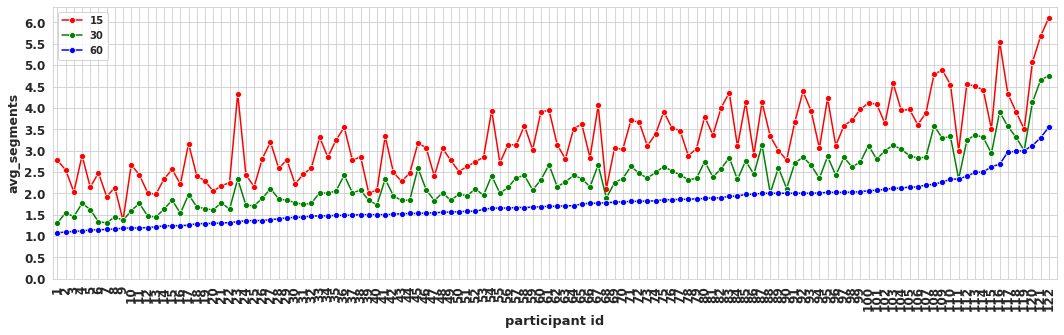

In [154]:
plot_segments_per_day(segments_per_day_diff_time_gaps)

In [155]:
tgap_60 = total_watch_segments.loc[total_watch_segments['time_gap'] == 60]
watch_wearing_cycles = (tgap_60.groupby('user')['segment', 'date']
                        .agg({'segment':'count','date':'nunique'})
                        .reset_index())

In [5]:
# watch_wearing_cycles

In [157]:
watch_wearing_cycles_per_day = watch_wearing_cycles['segment'].sum() / watch_wearing_cycles['date'].sum()
watch_wearing_cycles_per_day

1.8007361340271608

#### This will be less than previously computed 1.8 as this is mean of means (avg_segments_60)

In [158]:
watch_wearing_cycles_per_day = segments_per_day_diff_time_gaps[('avg_segments', 60)].mean()
watch_wearing_cycles_per_day

1.7653482482260618

In [113]:
data_hours = (total_watch_segments.loc[total_watch_segments['time_gap']==60]
              .groupby('user')['dur_mins','date']
              .agg({'dur_mins':'sum', 'date':'nunique'}))
data_hours['hours'] = data_hours['dur_mins'] / 60
data_hours['avg_hours_per_day'] = data_hours['hours'] / data_hours['date']

In [6]:
# data_hours.sort_values(by='avg_hours_per_day')

In [160]:
watch_wearing_hours_per_day = data_hours['hours'].sum() / data_hours['date'].sum()
watch_wearing_hours_per_day

6.429234603940151

### Compute statistics of detected valid episodes(excluding activity induded episodes) within these wacth wearing cycles e.g. valid events per hour, total valid events, duration of all the valid events and so on

In [ ]:
def total_detected_events(df, exclude_event_type=None):
    if exclude_event_type:
        df = df.loc[~(df['episode_class'] == exclude_event_type)]
    df['detected'] = 1
    user_total_events = (df.groupby('user')['detected']
                   .agg(['sum'])
                   .reset_index()
                   .rename(columns={'sum':'total_detected'})
                   )
    return user_total_events

In [ ]:
def watch_wearing_dur_in_hours(user_watch_wearing_segments):
    user_watch_wearing_dur_hours = (user_watch_wearing_segments.groupby('user')['dur_mins']
                                    .agg(['sum'])
                                    .rename(columns={'sum':'total_mins'})
                                    .assign(total_hours=lambda df:df['total_mins']/60))
    return user_watch_wearing_dur_hours

In [ ]:
def combine_total_events_with_watch_wearing_dur(user_total_events, user_watch_wearing_dur_hours):
    user_watch_hours_total_events = (pd.merge(user_watch_wearing_dur_hours, 
                                              user_total_events, on='user')
                                     .assign(event_per_hour=lambda df:df['total_detected']/df['total_hours']))
    return user_watch_hours_total_events    

In [84]:
def get_events_per_hour(nature_df, exclude, total_watch_segments):
    user_total_events = total_detected_events(nature_df, exclude)
    user_events_per_hour = pd.DataFrame()
    for time_gap in [15, 30, 60]:
        watch_segments = total_watch_segments.loc[total_watch_segments['time_gap'] == time_gap]
        user_watch_wearing_dur_hours = watch_wearing_dur_in_hours(watch_segments)
        user_watch_hours_total_events = combine_total_events_with_watch_wearing_dur(user_total_events, 
                                                                            user_watch_wearing_dur_hours)
        user_watch_hours_total_events['time_gap'] = time_gap
        user_events_per_hour = pd.concat([user_events_per_hour, user_watch_hours_total_events])
    return user_events_per_hour

In [85]:
user_events_per_hour_with_unsure = get_events_per_hour(nature_df, None, total_watch_segments).assign(events='all')
user_events_per_hour_with_valid = get_events_per_hour(nature_df, 3, total_watch_segments).assign(events='valid')

In [7]:
# display(user_events_per_hour_with_valid.head())

In [164]:
total_valid_events = (user_events_per_hour_with_valid.loc[user_events_per_hour_with_valid['time_gap'] == 60, 
                                                       'total_detected'].sum())
print(f"Total detected valid events: {total_valid_events}")

Total detected valid events: 128528


In [165]:
total_watch_wearing_hours = (user_events_per_hour_with_valid.loc[user_events_per_hour_with_valid['time_gap'] == 60, 
                                                       'total_hours'].sum())
print(f"Total watch wearing hours: {total_watch_wearing_hours}")

Total watch wearing hours: 50655.939444444455


In [166]:
valid_events_per_hour = (user_events_per_hour_with_valid.loc[user_events_per_hour_with_valid['time_gap'] == 60, 
                                                       'total_detected'].sum() / 
                   user_events_per_hour_with_valid.loc[user_events_per_hour_with_valid['time_gap'] == 60, 
                                                       'total_hours'].sum())
print(f"Valid events per hour: {valid_events_per_hour}")

Valid events per hour: 2.5372740375481464


In [167]:
total_valid_events_per_day = valid_events_per_hour * watch_wearing_hours_per_day
print(f"Total valid events per day: {total_valid_events_per_day}")

Total valid events per day: 16.312730041883487


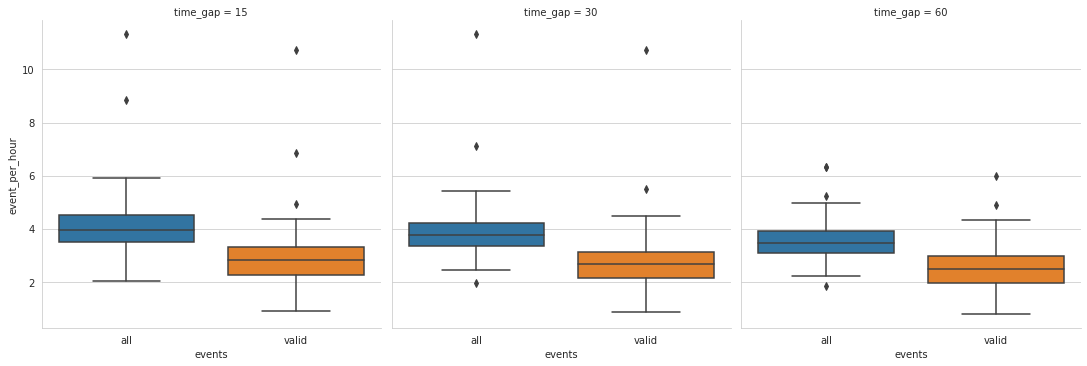

In [168]:
events_per_hour = pd.concat([user_events_per_hour_with_unsure, user_events_per_hour_with_valid])
sns.catplot(data=events_per_hour, kind='box', x='events', y='event_per_hour', col='time_gap');

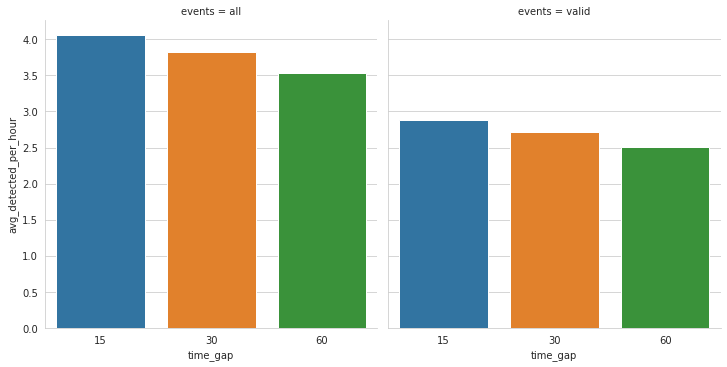

In [169]:
means = []
for include in ['all', 'valid']:
    df = user_events_per_hour_with_unsure if include == 'all'else user_events_per_hour_with_valid
    for time_gap in [15,30,60]:
        mean = (df.loc[df['time_gap']==time_gap, 'event_per_hour'].mean())
        means.append([include, time_gap, mean])
df_mean = pd.DataFrame(means, columns=['events', 'time_gap', 'avg_detected_per_hour'])
sns.catplot(data=df_mean, kind='bar', x='time_gap', y='avg_detected_per_hour', col='events');

### Following snippet is to update episode hour of each watch wearing cycle with appropriate hour index

In [43]:
def find_valleys(hours):
    valley_pos = []
    for i in range(1, len(hours)):
        if hours[i] < hours[i-1]:
            valley_pos.append(i)
    return valley_pos

In [44]:
def update_watch_wearing_hour(hours, valleys):
    for j in range(len(valleys)):
        st_idx = valleys[j]
        if j == len(valleys) - 1:
            en_idx = len(hours)
        else:
            en_idx = valleys[j+1]
        n_h = hours[st_idx - 1]
        for i in range(st_idx, en_idx):
            hours[i] += n_h
    return hours

In [93]:
hours = [1, 1, 2, 2, 3, 3, 3, 4, 5, 9, 1, 2, 2, 2, 2]
valleys = find_valleys(hours)
new_hours = update_watch_wearing_hour(hours, valleys)
new_hours

[1, 1, 2, 2, 3, 3, 3, 4, 5, 9, 10, 11, 11, 11, 11]